In [8]:
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from pathlib import Path
from typing import List, Dict

def get_chemical_isomorphisms(mol: Chem.Mol, suffix='-iso') -> List[Chem.Mol]:
    """
    Given a molecule, return a list of molecules where crystallographical ambiguity is resolved.
    """
    query: Chem.Mol = create_unelemental_query(mol)
    # these include all isomorphisms
    to_idx_map = lambda indxs: dict(zip(range(mol.GetNumHeavyAtoms()), indxs))  # noqa
    idx_maps = [to_idx_map(qidxs) for qidxs in mol.GetSubstructMatches(query, uniquify=False)]
    # these are replacement isomorphism
    idx_maps = remove_elemental_isomorphisms(idx_maps, mol)
    if len(idx_maps) == 0:
        raise ValueError(f'An unexplained error: no replacement_isomorphic mappings - before filtering: {idx_maps}')
    elif len(idx_maps) == 1:
        return [mol]
    else:
        return maps_to_mols(idx_maps, mol, suffix)


# dependent functions

def maps_to_mols(idx_maps: List[Dict[int, int]], mol: Chem.Mol, suffix) -> List[Chem.Mol]:
    conformer: Chem.Conformer = mol.GetConformer()  # noqa
    copies = []
    name = mol.GetProp('_Name') if mol.HasProp('_Name') else '_'
    for mi, mapping in enumerate(idx_maps):
        if mi == 0:
            # original was spiked to the front of the mappings
            copies.append(mol)
            continue
        copy = Chem.Mol(mol)
        coconfomer = copy.GetConformer()  # noqa
        for q, t in mapping.items():
            coconfomer.SetAtomPosition(q, conformer.GetAtomPosition(t))
        copy.SetProp('_Name', f'{name}{suffix}{mi}')
        copies.append(copy)
    return copies


def remove_elemental_isomorphisms(idx_maps: List[Dict[int, int]], mol: Chem.Mol) -> List[Dict[int, int]]:
    """
    Benzene can be mapped twelve ways. I do not want this. Only maps where the elements differ
    """
    unique = []
    seen = []
    # spiking in the original for zeroth position
    for m in [dict(zip(range(mol.GetNumHeavyAtoms(), mol.GetNumHeavyAtoms())))] + idx_maps:  # noqa
        # this could be done mathematically, but this is quicker to write
        element_hash = ''.join([mol.GetAtomWithIdx(i).GetSymbol() for i in m.values()])
        if element_hash in seen:
            continue
        unique.append(m)
        seen.append(element_hash)
    return unique


def create_unelemental_query(mol: Chem.Mol) -> Chem.Mol:
    """
    A Query mol where the elements are stripped.
    Changing the atomic Zahlen to 0, will not work as the atoms have to be QueryAtoms,
    which is what `arthorian_quest.enquire` does.
    """
    from arthorian_quest import enquire

    subs = {}
    for atom in mol.GetAtoms():   # noqa
        if atom.GetSymbol() == 'H':
            subs[atom.GetIdx()] = None
        elif atom.GetSymbol() not in 'CNO':
            continue
        elif not atom.GetIsAromatic():
            subs[atom.GetIdx()] = '[C,N,O]'
        else:
            subs[atom.GetIdx()] = 'a'
    return enquire(mol, subs)

def add_nitrogen_charges(mol) -> Chem.Mol:
    RDLogger.DisableLog('rdApp.*')
    mol.UpdatePropertyCache(strict=False)
    ps = Chem.DetectChemistryProblems(mol)
    if not ps:
        Chem.SanitizeMol(mol)
        RDLogger.EnableLog('rdApp.*')
        return mol
    for p in ps:
        if p.GetType() == 'AtomValenceException':
            at = mol.GetAtomWithIdx(p.GetAtomIdx())
            if at.GetAtomicNum() == 7 and at.GetFormalCharge() <= 0: #and at.GetExplicitValence() == 4:
                at.SetFormalCharge(1)
    Chem.SanitizeMol(mol)
    RDLogger.EnableLog('rdApp.*')
    return mol

hits = []

#for path in Path('mols').glob('*.mol'):
    #mol = add_nitrogen_charges(Chem.MolFromMolFile(path.as_posix(), sanitize=False))
    #mol.SetProp('_Name', path.stem)
    #hits.append(mol)

with Chem.SDMolSupplier('XX01ZVNS2B.corrected.sdf') as sdfh:
    hits = list(sdfh)

isomols = []
enumerator = rdMolStandardize.TautomerEnumerator()
for mol in hits:
    name = mol.GetProp('_Name')
    for tauto in enumerator.Enumerate(mol):
        tauto.SetProp('_Name', name + '-tauto1')
        isomols.extend(get_chemical_isomorphisms(tauto))
with Chem.SDWriter('isohits.sdf') as sdfh:
    for mol in isomols:
        sdfh.write(mol)

len(hits), len(isomols)

(50, 279)

In [10]:
import pandas as pd
df = pd.DataFrame([{'hits': [mol], 'smiles': Chem.MolToSmiles(mol), 'name': mol.GetProp('_Name') + '_r'} for mol in isomols])

In [11]:

from fragmenstein import Victor, Igor, Laboratory

df = pd.DataFrame([{'hits': [mol], 'smiles': Chem.MolToSmiles(mol), 'name': mol.GetProp('_Name') + '_r'} for mol in isomols])

lab = Laboratory(pdbblock=Path('template2.pdb').read_text(), run_plip=True)
df = lab.place(df)

[2024-07-12 11:33:45,558] CRITICAL - *** FileExistsError [Errno 17] File exists: 'output/x0051-0B-tauto1-r' for x0051_0B-tauto1_r


In [15]:
!rm -r output

^C


In [18]:
Victor.work_path = '/tmp/output'
Igor.init_pyrosetta()
vicky = Victor(pdb_block=Path('template2.pdb').read_text(), hits=[isomols[0]])

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python311.ubuntu 2024.16+release.bc4dfa1b240a4138da057c7de791d08506956c8d 2024-04-16T10:39:11] retrieved from: http://www.pyrosetta.org


In [21]:
vicky.place(Chem.MolToSmiles(isomols[0]), long_name='test')

In [22]:
vicky.get_plip_interactions()

{('hbond', 'TYR', 150): 1,
 ('pistack', 'TYR', 161): 2,
 ('hydroph_interaction', 'TYR', 161): 1}

In [27]:
intxn_cols = [col for col in df.columns if isinstance(col, tuple)]

In [38]:
df['clean_name'] = df['name'].str.extract(r'(x\d+)[-_](\d\w)').apply(lambda row: row[0] +'_'+row[1], axis=1)

In [313]:
df.values.shape

(279, 72)

In [335]:
def get_dendro_ordering(df):
    dendro = ff.create_dendrogram(df.values, orientation='right', labels=df.index)
    return dendro['layout']['yaxis']['ticktext']

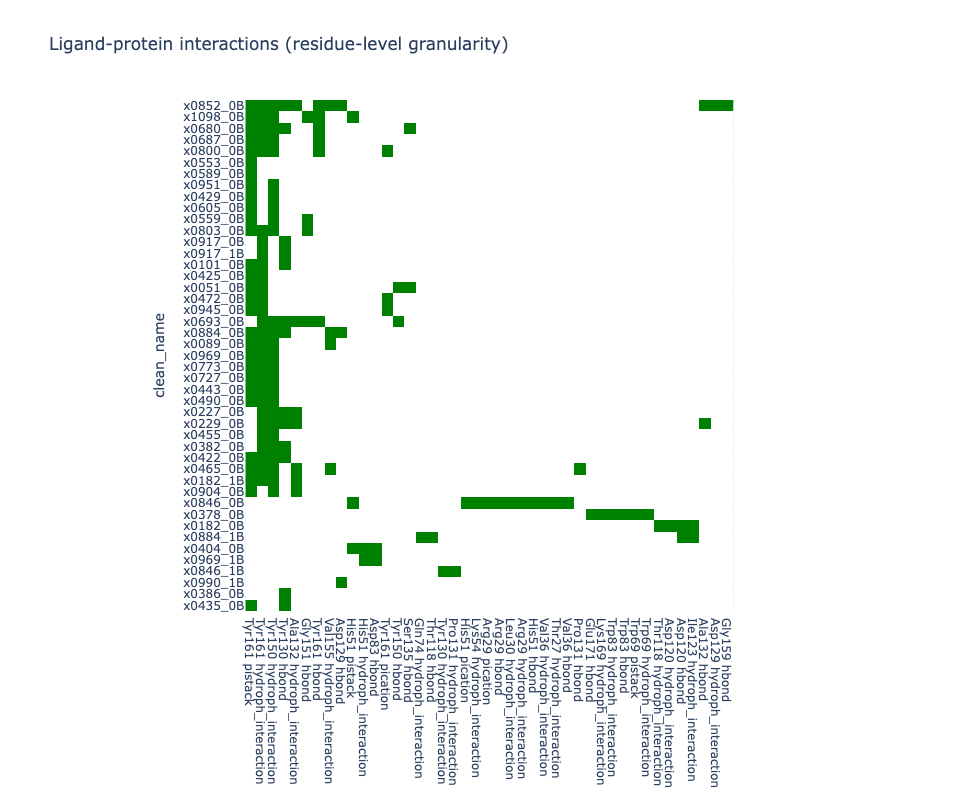

In [339]:
d = collapsed.loc[get_dendro_ordering(collapsed)]\
             .rename(columns={c: f'{c[1].capitalize()}{c[2]} {c[0]}' for c in collapsed.columns})

dt = d.transpose()
d = d[get_dendro_ordering(dt)]

fig = px.imshow(d,
          color_continuous_scale=[(0, 'white'), (1, 'green')],
          title='Ligand-protein interactions (residue-level granularity)', height=800, width=800)
fig.update_xaxes(tickmode='array', tickvals=list(range(len(jaccard.columns))))
fig.update_yaxes(tickmode='array', tickvals=list(range(len(jaccard.index))))
fig.update_coloraxes(showscale=False)
fig

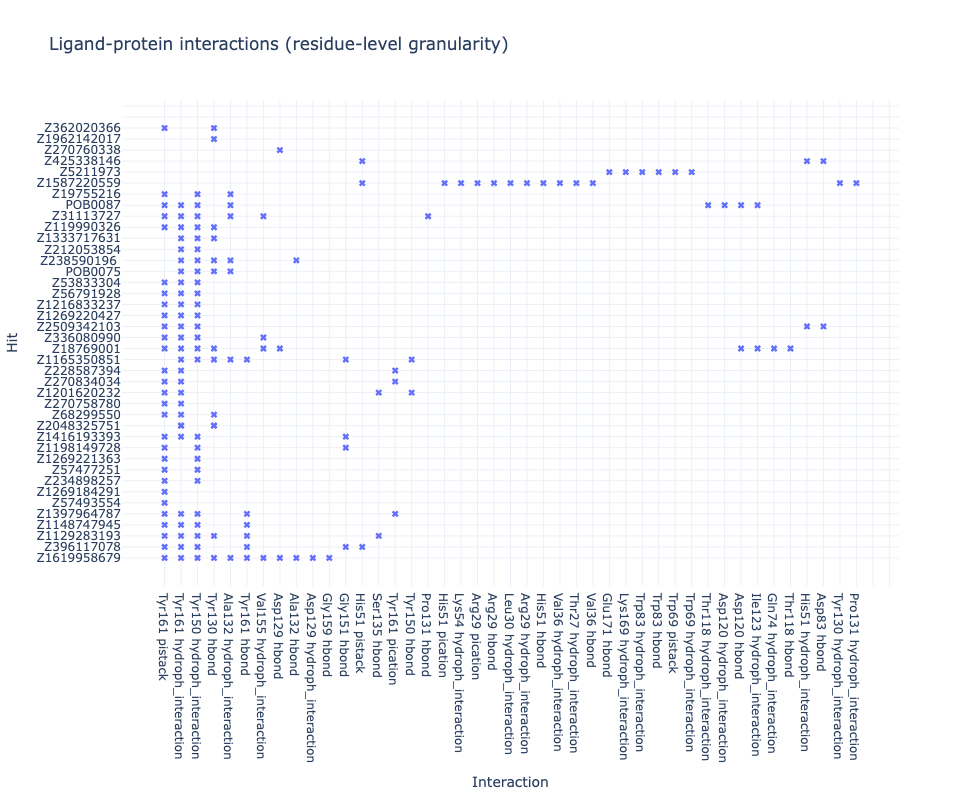

In [358]:
long = pd.DataFrame([(xcode2zcode[re.search(r'(x\d+)', name).group(1)], col) for name, row in d.iterrows() for col, v in row.items() if v], columns=['Hit', 'Interaction'])

fig = px.scatter(long, x='Interaction', y='Hit', 
                 template='plotly_white',
                 title='Ligand-protein interactions (residue-level granularity)', height=800, width=800)
fig.update_traces(marker=dict(symbol='x'))
fig.update_xaxes(tickmode='array', tickvals=list(range(len(jaccard.columns))))
fig.update_yaxes(tickmode='array', tickvals=list(range(len(jaccard.index))))
fig.update_coloraxes(showscale=False)

In [296]:
import numpy as np
from sklearn.metrics import jaccard_score
from typing import List
import itertools

x = df.groupby('clean_name')[intxn_cols].sum().astype(bool)
collapsed = x.loc[x.sum(axis=1) > 0]
fps = collapsed.values
n = len(collapsed)
jaccard_matrix = np.ones((n, n))
for i, j in itertools.combinations(range(n), r=2):
    jaccard_index = jaccard_score(fps[i], fps[j])
    jaccard_matrix[i, j] = jaccard_index
    jaccard_matrix[j, i] = jaccard_index

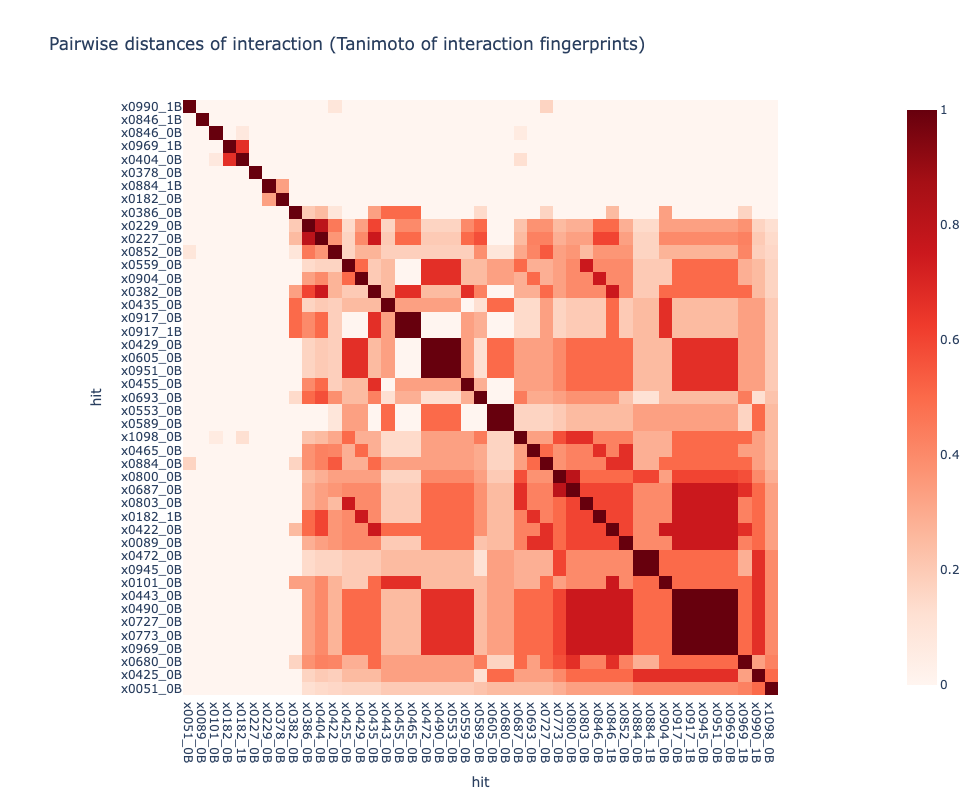

In [297]:
import plotly.express as px
#jaccard_matrix[np.triu_indices_from(jaccard_matrix)] = np.nan
jaccard = pd.DataFrame(jaccard_matrix, columns=collapsed.index, index=collapsed.index)
jaccard = jaccard.sort_values(jaccard.columns.to_list()).copy()
jaccard.index.name = 'hit'
jaccard.columns.name = 'hit'
fig = px.imshow(jaccard[jaccard.index],
          color_continuous_scale='reds',
          title='Pairwise distances of interaction (Tanimoto of interaction fingerprints)', height=800, width=800)
fig.update_xaxes(tickmode='array', tickvals=list(range(len(jaccard.columns))), ticktext=jaccard.columns)
fig.update_yaxes(tickmode='array', tickvals=list(range(len(jaccard.index))), ticktext=jaccard.index)
fig

This is glitched!


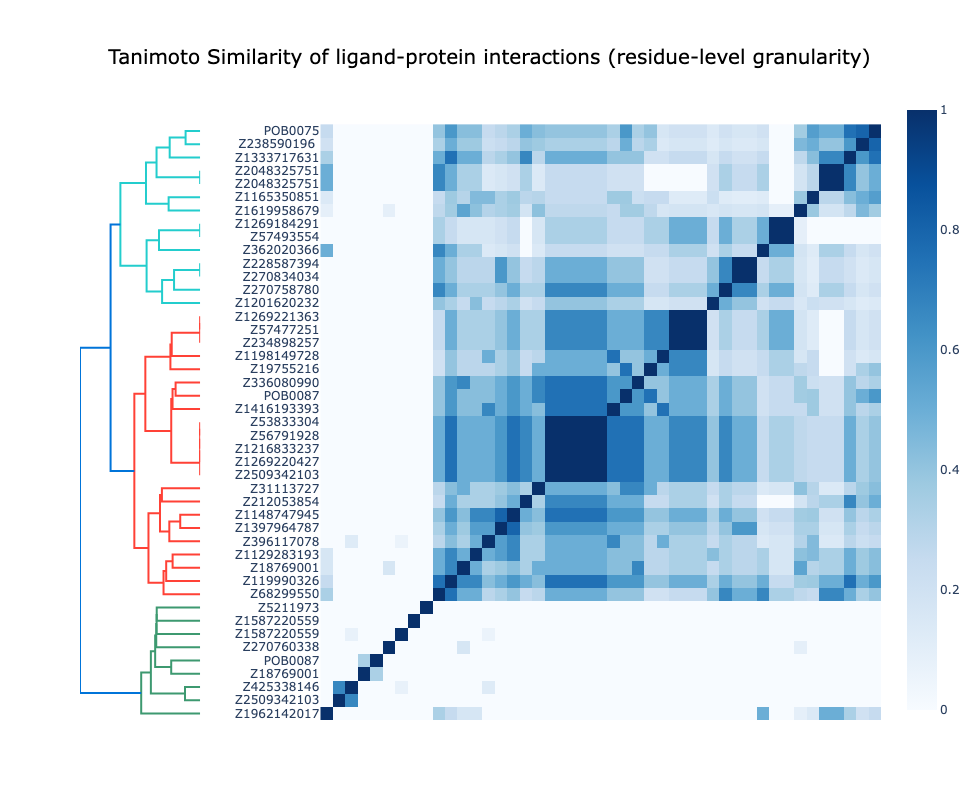

In [332]:
print('This is glitched!')

import plotly.graph_objects as go
import plotly.figure_factory as ff

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import random
import string
import re

# Assuming jaccard is already defined as a DataFrame somewhere above this snippet
fig = ff.create_dendrogram(jaccard.values, orientation='bottom')
fig.for_each_trace(lambda trace: trace.update(visible=False))

for i in range(len(fig['data'])):
    fig['data'][i]['yaxis'] = 'y2'

# Create Side Dendrogram
dendro_side = ff.create_dendrogram(jaccard.values, orientation='right', labels=jaccard.index)
for i in range(len(dendro_side['data'])):
    dendro_side['data'][i]['xaxis'] = 'x2'

# Add Side Dendrogram Data to Figure
for data in dendro_side['data']:
    fig.add_trace(data)

# Create Heatmap
dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
heat_data = jaccard.loc[dendro_leaves][dendro_leaves].values

heatmap = [
    go.Heatmap(
        x=dendro_leaves,
        y=dendro_leaves,
        z=heat_data,
        colorscale='Blues'
    )
]

heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']
y_tickvals = heatmap[0]['y']
meta = pd.read_csv('metadata.csv')
meta['xcode'] = meta.RealCrystalName.str.extract(r'(x\d+)')
xcode2zcode = meta.set_index('xcode').alternate_name.to_dict()
zdendro_leaves = [xcode2zcode[re.search(r'(x\d+)', x).group(1)] for x in dendro_leaves]

# Add Heatmap Data to Figure
for data in heatmap:
    fig.add_trace(data)

# Edit Layout
fig.update_layout(
    width=1000, 
    height=800,
    showlegend=False, 
    hovermode='closest',
    title=dict(
        text='Tanimoto Similarity of ligand-protein interactions (residue-level granularity)',
        x=0.5,
        xanchor='center',
        yanchor='top'
    ),
    title_font=dict(
        size=20,
        color='black'
    )
)

# Edit xaxis
fig.update_layout(
    xaxis=dict(
        domain=[.30, 1],
        mirror=False,
        showgrid=False,
        showline=False,
        zeroline=False,
        ticks=""
    )
)

# Edit xaxis2
fig.update_layout(
    xaxis2=dict(
        domain=[0, .15],
        mirror=False,
        showgrid=False,
        showline=False,
        zeroline=False,
        showticklabels=False,
        ticks=""
    )
)

# Edit yaxis
fig.update_layout(
    yaxis=dict(
        domain=[0, 1],
        mirror=False,
        showgrid=False,
        showline=False,
        zeroline=False,
        showticklabels=True,  # Show tick labels
        ticktext=zdendro_leaves,  # Set the tick labels to dendro_leaves
        tickvals=y_tickvals,
        ticks=""
    )
)

# Edit yaxis2
fig.update_layout(
    yaxis2=dict(
        domain=[.825, .975],
        mirror=False,
        showgrid=False,
        showline=False,
        zeroline=False,
        showticklabels=False,
        ticks=""
    )
)

fig.update_layout(
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    xaxis_tickfont=dict(color='rgba(0,0,0,0)')
)

fig.show()


In [309]:
' '.join(dendro_leaves[:9])

'x0386_0B x0969_1B x0404_0B x0884_1B x0182_0B x0990_1B x0846_0B x0846_1B x0378_0B'

In [183]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import hamming

distance_matrix = pairwise_distances(fps, metric='hamming')
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
clusters = kmeans.fit_predict(distance_matrix)
clustered = pd.Series(clusters, index=collapsed.index, )

In [208]:
import operator
c = collapsed.sum(axis=1).sort_values().index
for gi, g in collapsed.loc[c].groupby(clustered):
    s = g.sum()
    s.loc[s != 0]
    itxns = [f'{ixn}:{rn}{ri}' for ixn, rn, ri in sorted(s.loc[s != 0].index, key=operator.itemgetter(2))]
    print(f'cluster #{gi} ({" ".join(itxns)})')
    print(f'disable; enable template2 {" ".join(g.index)}\n')

cluster #0 (hbond:TYR130 hydroph_interaction:TYR150 pistack:TYR161 hydroph_interaction:TYR161)
disable; enable template2 x0386_0B x0435_0B x0917_0B x0917_1B x0101_0B x0382_0B

cluster #1 (hydroph_interaction:ASP129 hbond:ASP129 hbond:TYR130 hydroph_interaction:ALA132 hbond:ALA132 hydroph_interaction:TYR150 hydroph_interaction:VAL155 hbond:GLY159 pistack:TYR161 hydroph_interaction:TYR161 hbond:TYR161)
disable; enable template2 x0852_0B

cluster #2 (hbond:TYR130 hydroph_interaction:ALA132 hydroph_interaction:TYR150 hbond:GLY151 hydroph_interaction:VAL155 pistack:TYR161 hydroph_interaction:TYR161 hbond:TYR161)
disable; enable template2 x0455_0B x0727_0B x0773_0B x0490_0B x0443_0B x0969_0B x0422_0B x0803_0B x0182_1B x0089_0B x0687_0B

cluster #3 (hydroph_interaction:THR27 hydroph_interaction:ARG29 hbond:ARG29 pication:ARG29 hydroph_interaction:LEU30 hbond:VAL36 hydroph_interaction:VAL36 pistack:HIS51 hbond:HIS51 pication:HIS51 hydroph_interaction:LYS54)
disable; enable template2 x0846_0B



In [228]:
#0 S1
#1 x0852_0B special S1
#2 S1
#4 S1'

In [212]:
moldex = {}
df['cluster'] = df.clean_names.map(clustered.to_dict())
for i, row in df.sort_values('∆∆G').drop_duplicates('clean_name'):
    mol = row.minimized_mol
    mol.SetProp('_Name', row.clean_name)
    moldex[row.clean_name] = mol



SyntaxError: unterminated string literal (detected at line 8) (280701804.py, line 8)

In [229]:
df['cluster'] = df.clean_name.map(clustered.to_dict())

with Chem.SDWriter('cluster_hits.sdf') as sdfh:
    for i, row in df.loc[~df.cluster.isna()].sort_values('∆∆G').drop_duplicates('cluster').iterrows():
            mol = row.minimized_mol
            mol.SetProp('_Name', row.clean_name)
            sdfh.write(mol)

In [232]:
' '.join(df.loc[~df.cluster.isna()].sort_values('∆∆G').drop_duplicates('cluster').clean_name.to_list())

'x1098_0B x0727_0B x0904_0B x0852_0B x0846_0B x0101_0B x0693_0B x0990_1B x0884_1B x0378_0B'

0.5159518888790297
count    27.000000
mean      0.147234
std       0.030283
min       0.088115
25%       0.133929
50%       0.146104
75%       0.154841
max       0.235075
dtype: float64


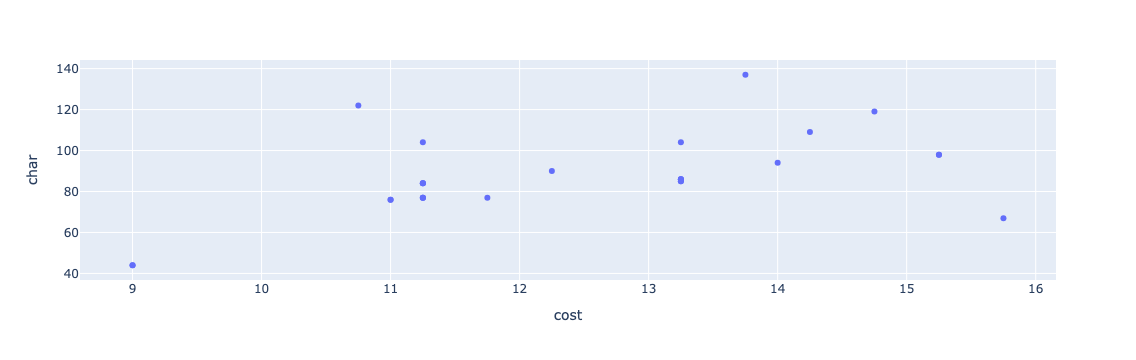

In [387]:
xcode2zcode

{'x0051': 'Z1201620232',
 'x0089': 'Z336080990',
 'x0101': 'Z68299550',
 'x0182': 'POB0087',
 'x0227': 'POB0075',
 'x0229': 'Z238590196 ',
 'x0378': 'Z5211973',
 'x0382': 'Z1333717631',
 'x0386': 'Z1962142017',
 'x0404': 'Z425338146',
 'x0422': 'Z119990326',
 'x0425': 'Z270758780',
 'x0429': 'Z57477251',
 'x0435': 'Z362020366',
 'x0443': 'Z56791928',
 'x0455': 'Z212053854',
 'x0465': 'Z31113727',
 'x0472': 'Z270834034',
 'x0490': 'Z53833304',
 'x0553': 'Z57493554',
 'x0559': 'Z1198149728',
 'x0589': 'Z1269184291',
 'x0605': 'Z1269221363',
 'x0680': 'Z1129283193',
 'x0687': 'Z1148747945',
 'x0693': 'Z1165350851',
 'x0727': 'Z1216833237',
 'x0773': 'Z1269220427',
 'x0788': 'Z1328968520',
 'x0800': 'Z1397964787',
 'x0803': 'Z1416193393',
 'x0846': 'Z1587220559',
 'x0852': 'Z1619958679',
 'x0884': 'Z18769001',
 'x0904': 'Z19755216',
 'x0917': 'Z2048325751',
 'x0945': 'Z228587394',
 'x0951': 'Z234898257',
 'x0969': 'Z2509342103',
 'x0990': 'Z270760338',
 'x1098': 'Z396117078'}